In [2]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.colors as colors
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [3]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [4]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [5]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

759it [00:24, 31.44it/s]


### PPT Levels in different U.S. States


In [6]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

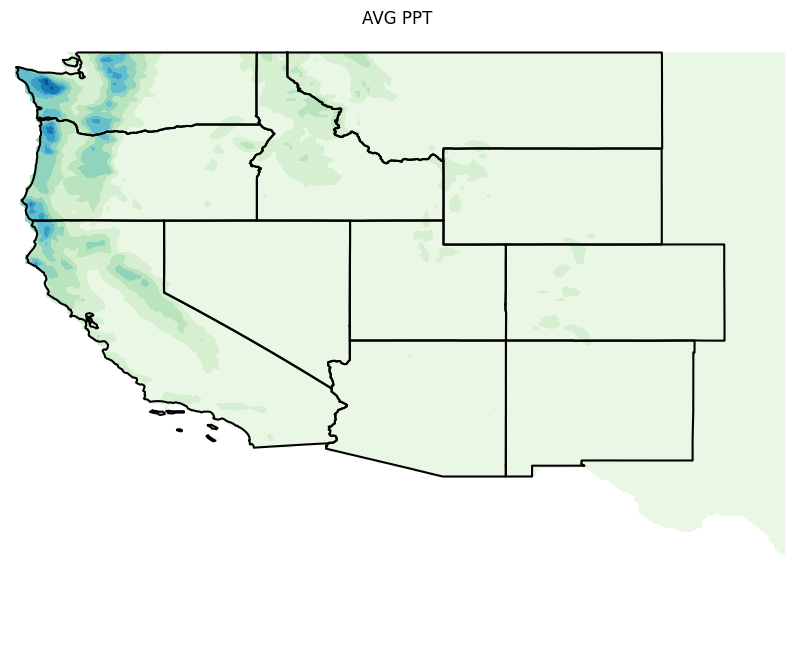

In [7]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [8]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

1644it [00:16, 100.59it/s]


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


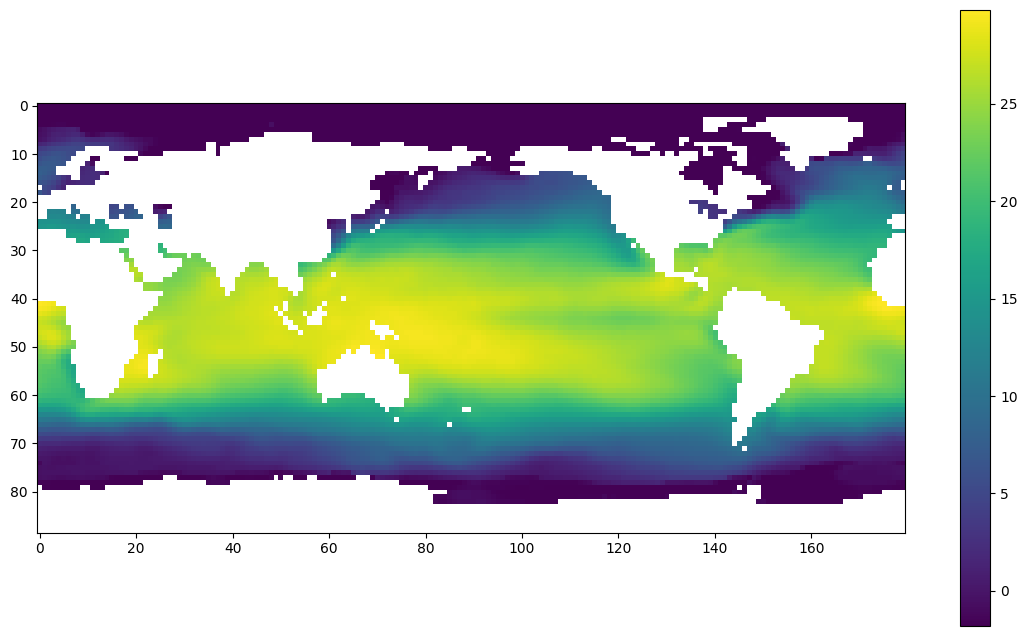

(1644,)

In [9]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_df["sst"].shape

In [10]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [11]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [12]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [13]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [14]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [15]:
clusters = np.load("clusters.npy")

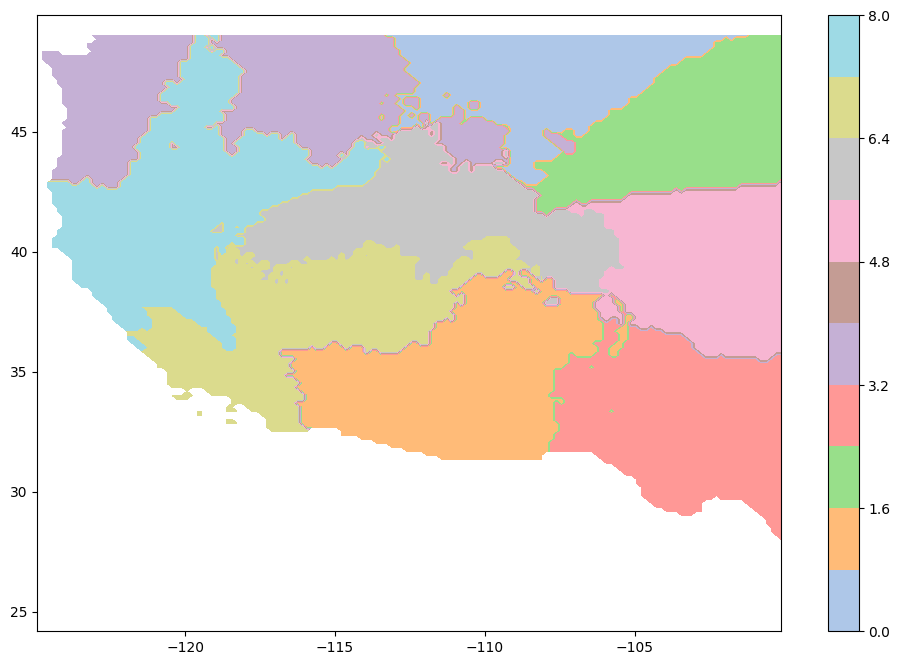

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [16]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters): ", np.unique(clusters))

In [17]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters)
avg_clusters

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_49646/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

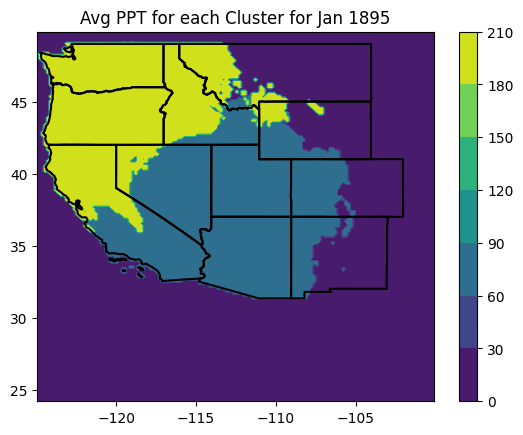

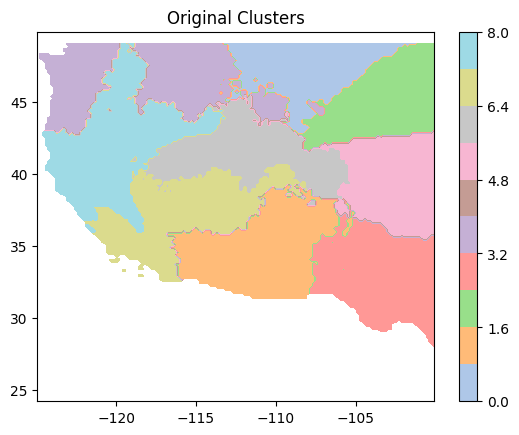

In [18]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [19]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters, return_image=False)[:-1]
)

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_49646/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_49646/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [20]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [21]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [22]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels and processing ppt clusters


In [23]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)

ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
# get all 9 clusters in a list, where each cluster is the ith column in ppt_data
clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
clusters = np.array(clusters)

In [24]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)

### Process sst data for forest tree classification on entire dataset


In [25]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    IO_TP_sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data_all = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

### Check if y labels are distributed


In [26]:
# put all data from y_labels into a single, one-dimensional array
ppt_data_all = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
ppt_data_all = np.array([[y for y in x] for x in ppt_data_all])
ppt_data_all.reshape(1, -1)
# count the number of times each label appears in the data
unique, counts = np.unique(ppt_data_all, return_counts=True)
d = dict(zip(unique, counts))
d

{0.0: 1647, 1.0: 1647, 2.0: 1647, 3.0: 1647}

### Process data for PCA pre-processing with regions

We need to split the data into the following regions, so we use array slicing

![](PCA_regions.png)

Now that we have the regions, we'll split the sst data into regions using these approximate coordinates we have estimated. Once the data is separated into regions, we can use principal component analysis to reduce dimensionality and assess the effect on random forest training quality.


In [27]:
sst_squeezed = np.array([sst_condensed["sst"].iloc[row].squeeze((0,1)) for row in range(len(sst_condensed))])
pca = PCA(n_components=2)

def split_and_pca(x_start, x_end, y_start, y_end):
    """Slice the SST data according to the region boundaries and perform PCA"""
    region = sst_squeezed[:, y_start:y_end, x_start:x_end] # slice according to region boundaries
    region = region.reshape(sst_squeezed.shape[0], -1) # flatten SST data into one dimension
    mean = np.nanmean(region) # need the mean to fill in nan values
    region = np.nan_to_num(region, copy=False, nan=mean) # replace nan with mean
    region = pca.fit_transform(region) # perform PCA
    return region

# IO -> data[34:55][10:67]
# TP -> data[34:55][55:143]
# NP -> data[11:32][59:128]
# WP -> data[28:49][55:84]

TP = split_and_pca(55, 144, 34, 56)
IO = split_and_pca(10, 68, 34, 56)
WP = split_and_pca(55, 85, 28, 50)
NP = split_and_pca(59, 129, 11, 33)

sst_data_all_pca = np.concatenate((TP, IO, WP, NP), axis=1)
# put back in original dataframe format
sst_condensed_pca = sst_condensed.copy()
for row in range(len(sst_condensed_pca)):
    sst_condensed_pca["sst"].iloc[row] = sst_data_all_pca[row]

sst_condensed_pca["sst"].iloc[0].shape

(8,)

Now we have to create chunks of 24 preceding months to correspond to each y label month (since we are predicting one month's ppt data based on the preceding 24 months of sst data)


In [28]:
def chunk_sst_to_label(pca_data):
    """
    Take SST data (preprocessed by PCA on each region), type is a DataFrame organized by date
    Return 732 x num_features numpy array, where each row is the 24 months of SST data (reduced to some number of dimensions by PCA) preceding the y label date
    """
    sst_24_months = []

    for date in y_labels.index:
        start_date = date - pd.DateOffset(months=23)
        end_date = date
        # get 24 months of pca sst data preceding the y label date
        sst_in_range = np.array(pca_data.loc[start_date:end_date, 'sst'].tolist()).flatten()
        # append to the list of rows
        sst_24_months.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

    # convert to DataFrame
    sst_24_months = pd.DataFrame(sst_24_months)
    # convert dates to period
    sst_24_months["start date"] = sst_24_months["start date"].dt.to_period('M')
    sst_24_months["end date"] = sst_24_months["end date"].dt.to_period('M')
    # convert to final raw numpy array with only the sst data
    sst_24_months = np.array([xi.tolist() for xi in np.array(sst_24_months[:]["sst rows"])])
    print(f"sst_24_months shape: {sst_24_months.shape}")
    
    return sst_24_months

sst_pca = chunk_sst_to_label(sst_condensed_pca)

sst_24_months shape: (732, 192)


In [29]:
def get_cluster_data(ind):
    X_train, X_test, y_train, y_test = train_test_split(sst_pca, clusters[ind], test_size=0.1, random_state=4)
    return X_train, X_test, y_train, y_test

## Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flattened sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [30]:
trials = []
conf_preds = []
conf_labels = []
importances = []
for trial in range(5):
    accuracies = []
    for i in range(len(clusters)):
        X_train, X_test, y_train, y_test = get_cluster_data(i)

        rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=200) # since there are only 4 possible outputs, we use a Classifier
        rf.fit(X_train, y_train)
        importances.append(rf.feature_importances_)
        y_pred = rf.predict(X_test)  # changed to X_train to see if confusion matrix still skewed

        accuracies.append(accuracy_score(y_test, y_pred))
        conf_preds.append(y_pred)
        conf_labels.append(y_test)  # changed to y_train to see if confusion matrix still skewed
    trials.append(accuracies)

trials = np.array(trials)
# get the mean accuracy for each cluster
mean_accuracies = np.mean(trials, axis=0)
# np.savetxt("_______.csv", trials, delimiter=",")


### Find Most Important Month


In [31]:
by_month = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_month = np.mean(by_month, axis=2) # average the importances across the 8 features to get total importance for the month
by_month = np.sum(by_month, axis=0) # sum the importances across the 24 months to get total importance for all trials for that month
by_month


array([0.2925  , 0.389375, 0.065   , 0.165625, 0.23625 , 0.169375,
       0.349375, 0.431875, 0.0575  , 0.10875 , 0.169375, 0.20375 ,
       0.310625, 0.406875, 0.086875, 0.191875, 0.21125 , 0.201875,
       0.365   , 0.463125, 0.1375  , 0.139375, 0.2575  , 0.214375])

### Find Most Important Region


In [32]:
by_region = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_region.shape
by_region = np.mean(by_region, axis=1) # average the importances across the 24 months to get total importance for 8 features
by_region = np.sum(by_region, axis=0) # sum the importances across the 8 features to get total importance for all trials for that month
regions = [by_region[0] + by_region[1], by_region[2] + by_region[3], by_region[4] + by_region[5], by_region[6] + by_region[7]]
regions


[0.5572916666666667,
 0.5502083333333333,
 0.3327083333333334,
 0.43479166666666685]

### Graphing results


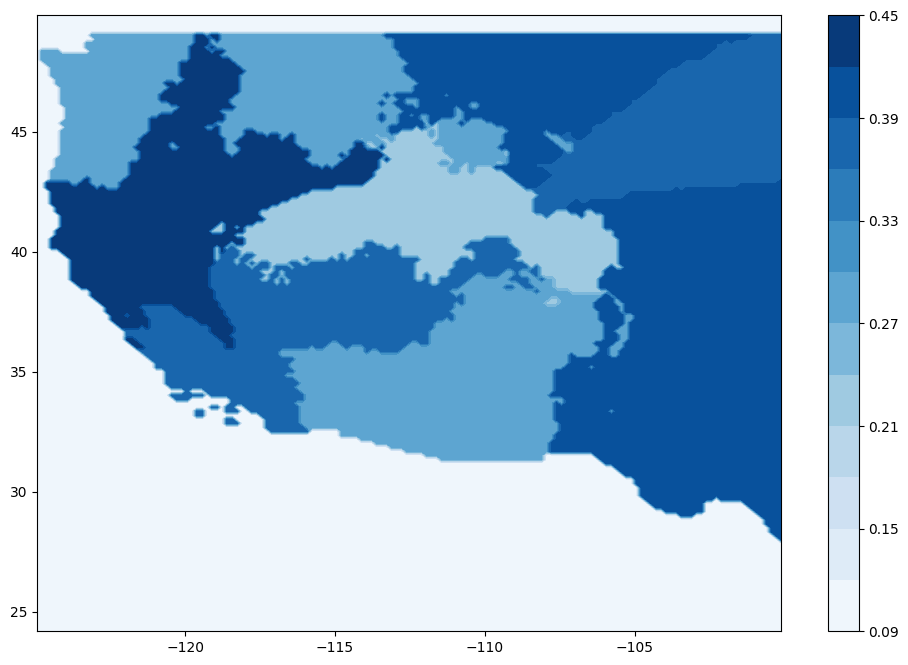

In [33]:
# clusters is 155x150 grid of values 0-8 -> convert to grid of same size with accuracy values

cluster_map_raw = np.load("clusters.npy")
cluster_map = np.where(np.isnan(cluster_map_raw), -1, cluster_map_raw)  # replace NaNs with -1
cluster_map = cluster_map.astype(int) # convert to integer
# replace all cluster numbers with their corresponding accuracy 
cluster_map = mean_accuracies[cluster_map]
cluster_map = np.where(np.isnan(cluster_map_raw), 0.1, cluster_map)  # replace where NaNs originally were with 0
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, cluster_map, levels=10, cmap="Blues")
plt.colorbar()
plt.show()


### Confusion Matrix


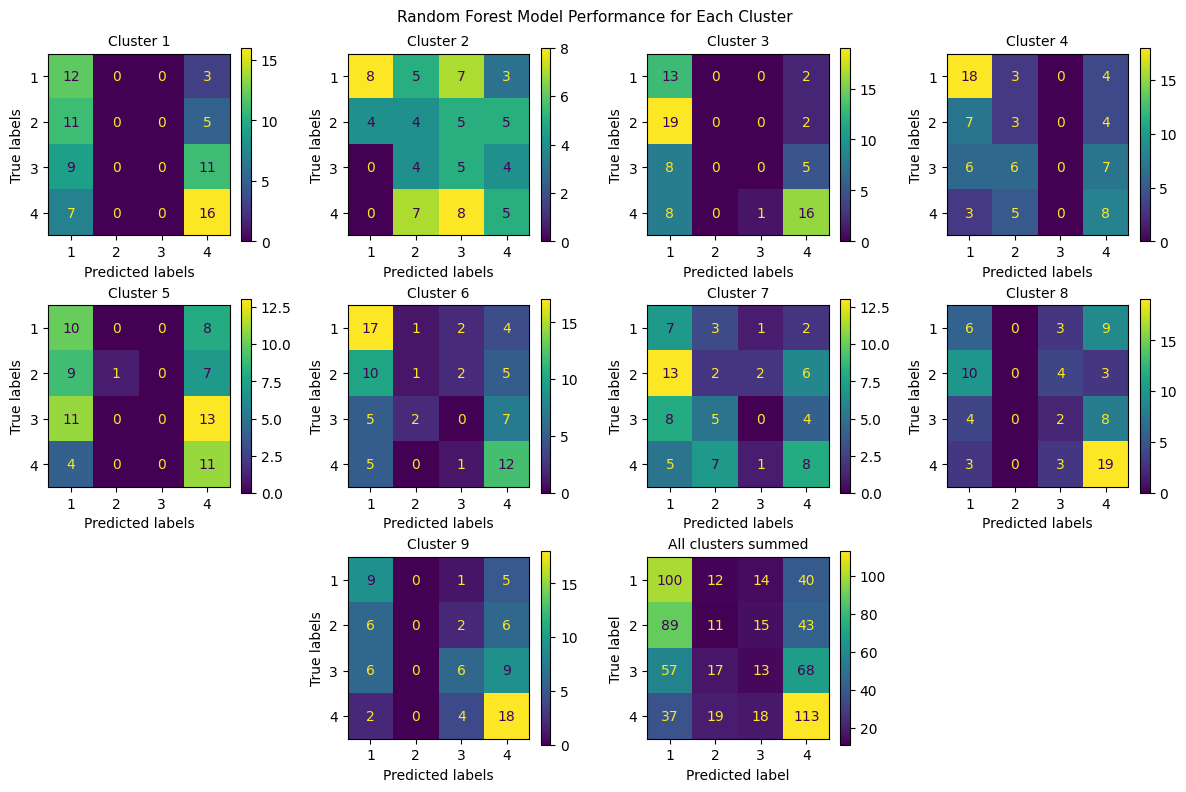

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(predictions, correct_labels, title="", num_clusters=9):
    """ Plot the confusion matrices for a model for each cluster
    Args: 
        predictions (list): A list of 9 lists, where the ith list corresponds to the model predictions for cluster i+1.
        correct_labels (list): A list of 9 lists, where the ith list corresponds to the actual labels for cluster i+1
        title (str) (optioanl): A title for the figure
        num_clusters (int): The number of clusters to plot
    """
    if len(predictions) < num_clusters or len(correct_labels) < num_clusters:
        raise ValueError(f"Length of predictions / labels is less than number of clusters")
    if len(predictions) != len(correct_labels):
        print(f"Prediction and label length mismatch. prediction length: {len(predictions)} label length: {len(correct_labels)}. Plotting only the first 9 arrays from each list")
        predictions = predictions[:9]
        correct_labels = correct_labels[:9]
    if len(predictions) != num_clusters or len(correct_labels) != num_clusters:
        print(f"Mismatch between number of clusters and predictions/labels. prediction length: {len(predictions)} label length: {len(correct_labels)} does not equal {num_clusters}. Plotting only the first 9 arrays from each list")
        predictions = predictions[:9]
        correct_labels = correct_labels[:9]
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,8))
    spec = fig.add_gridspec(5, 5)
    flattened_axes = axes.flatten()
    for i in range(9):
        if i == 8:
            flattened_axes[8].set_visible(False)
            flattened_axes[11].set_visible(False)
            a = flattened_axes[9]
        else:
            a = flattened_axes[i]
        ConfusionMatrixDisplay.from_predictions([int(x + 1) for x in correct_labels[i]], [int(x + 1) for x in predictions[i]], ax=a)
        a.set_title(label=f'Cluster {i+1}', fontdict={'fontsize':10})
        a.set_xlabel(xlabel='Predicted labels',fontdict={'fontsize':10})
        a.set_ylabel(ylabel='True labels',fontdict={'fontsize':10})
        i += 1
    ConfusionMatrixDisplay.from_predictions([int(x[i] + 1) for x in correct_labels for i in range(len(x))], [int(x[i]+1) for x in predictions for i in range(len(x))], ax=flattened_axes[10])
    flattened_axes[10].set_title(label="All clusters summed", fontdict={'fontsize':10})
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()
    plt.show()


plot_confusion_matrices(conf_preds[:9], conf_labels[:9], "Random Forest Model Performance for Each Cluster")

## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [35]:
# params = {
#     'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
#     'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
#     'n_estimators': [10,25,30,50,100,200]
# }

# # Assuming we have a list of clusters called 'clusters'
# # and a function 'get_cluster_data' that returns X_train and y_train for a given cluster
# best_params = {}

# for i in range(len(clusters)):
#     X_train, _, y_train, _ = get_cluster_data(i)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator=rf,
#                             param_grid=params,
#                             cv = 4,
#                             n_jobs=-1, verbose=1, scoring="accuracy")

#     grid_search.fit(X_train, y_train)
        
#         # Store the best parameters for the current cluster
#     best_params[i] = grid_search.best_params_
#     best_score = grid_search.best_score_
#     best_esty = grid_search.best_estimator_
#     print(f"best accuracy cluster {i}: {best_score}")
#     print(f"best estimators cluster {i}: {best_esty}")
#     print(f"best params for cluster {i}: {best_params[i]}")


## Trying Neural Network

Creating and training a logistic regression model


#### Model


In [36]:
# change to built in methods
class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(num_regions, 20),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [37]:
def gradient_descent(model, loss_func, train_dataset, valid_dataset, optimizer, steps=5000, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    losses = []
    valid_losses = []
    for step in tqdm(range(steps)):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for x_valid_batch, y_valid_batch in valid_loader:
                valid_loss = loss_func(model(x_valid_batch), y_valid_batch)
                running_valid_loss += valid_loss.item()
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps}, Training Loss: {avg_loss}, Validation Loss: {avg_valid_loss}")

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses


def calculate_accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        return correct / total, predicted

# Iterate for all 8 clusters
nn_train_predictions_all_clusters = []
nn_test_predictions_all_clusters = []
nn_train_labels_all_clusters = []
nn_test_labels_all_clusters = []

for i in range(len(clusters)):
    print(f"\nBegin training model for cluster {i+1}")
    # Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Initialize the model and optimizer
    model = RainPrediction(X_train.shape[1], 4)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run the training
    losses, valid_losses = gradient_descent(
        model, nn.CrossEntropyLoss(), train_dataset, test_dataset, optimizer, steps=150
    )

    train_accuracy, nn_train_predictions = calculate_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy, nn_test_predictions = calculate_accuracy(model, X_test_tensor, y_test_tensor)

    nn_train_predictions_all_clusters.append(nn_train_predictions.tolist())
    nn_test_predictions_all_clusters.append(nn_test_predictions.tolist())
    nn_train_labels_all_clusters.append(y_train_tensor.tolist())
    nn_test_labels_all_clusters.append(y_test_tensor.tolist())

    print(f"Training accuracy for cluster {i+1}: {train_accuracy * 100}%")
    print(f"Test accuracy for cluster {i+1}: {test_accuracy * 100}%")


Begin training model for cluster 1


 18%|█▊        | 27/150 [00:00<00:01, 90.30it/s]

Step 10/150, Training Loss: 1.3393812504681675, Validation Loss: 1.356677532196045
Step 20/150, Training Loss: 1.2813496372916482, Validation Loss: 1.3452662229537964
Step 30/150, Training Loss: 1.2764647873965176, Validation Loss: 1.4140135645866394


 41%|████      | 61/150 [00:00<00:00, 98.05it/s]

Step 40/150, Training Loss: 1.253227093003013, Validation Loss: 1.3949796557426453
Step 50/150, Training Loss: 1.2218798290599475, Validation Loss: 1.4222413301467896
Step 60/150, Training Loss: 1.1882170763882725, Validation Loss: 1.3610453009605408


 57%|█████▋    | 85/150 [00:00<00:00, 108.61it/s]

Step 70/150, Training Loss: 1.1660500764846802, Validation Loss: 1.367735207080841
Step 80/150, Training Loss: 1.1458813656460156, Validation Loss: 1.3871724009513855
Step 90/150, Training Loss: 1.0884099819443442, Validation Loss: 1.299822211265564


 80%|████████  | 120/150 [00:01<00:00, 110.11it/s]

Step 100/150, Training Loss: 1.080649029124867, Validation Loss: 1.446608543395996
Step 110/150, Training Loss: 1.0861515998840332, Validation Loss: 1.4054468274116516
Step 120/150, Training Loss: 1.0492620088837363, Validation Loss: 1.4104644060134888


100%|██████████| 150/150 [00:01<00:00, 102.48it/s]


Step 130/150, Training Loss: 1.0530773672190579, Validation Loss: 1.328801155090332
Step 140/150, Training Loss: 1.012459467757832, Validation Loss: 1.337217628955841
Step 150/150, Training Loss: 1.0404165929014033, Validation Loss: 1.4643490314483643
Final training loss: 1.0404165929014033
Final validation loss: 1.4643490314483643
Training accuracy for cluster 1: 57.75075987841946%
Test accuracy for cluster 1: 40.54054054054054%

Begin training model for cluster 2


 17%|█▋        | 26/150 [00:00<00:01, 113.26it/s]

Step 10/150, Training Loss: 1.3856837749481201, Validation Loss: 1.3968918323516846
Step 20/150, Training Loss: 1.3301518180153586, Validation Loss: 1.4319453835487366
Step 30/150, Training Loss: 1.3024983622811057, Validation Loss: 1.4623085260391235


 34%|███▍      | 51/150 [00:00<00:00, 107.30it/s]

Step 40/150, Training Loss: 1.2850671356374568, Validation Loss: 1.4764770865440369
Step 50/150, Training Loss: 1.27177555994554, Validation Loss: 1.4998460412025452


 49%|████▊     | 73/150 [00:00<00:00, 93.00it/s] 

Step 60/150, Training Loss: 1.259385260668668, Validation Loss: 1.4676861763000488
Step 70/150, Training Loss: 1.21721182086251, Validation Loss: 1.5064053535461426


 65%|██████▍   | 97/150 [00:00<00:00, 103.71it/s]

Step 80/150, Training Loss: 1.1818060333078557, Validation Loss: 1.5150561332702637
Step 90/150, Training Loss: 1.1764391335574063, Validation Loss: 1.5746484398841858
Step 100/150, Training Loss: 1.1426677703857422, Validation Loss: 1.568063735961914


 89%|████████▉ | 134/150 [00:01<00:00, 114.62it/s]

Step 110/150, Training Loss: 1.1632324132052334, Validation Loss: 1.7417648434638977
Step 120/150, Training Loss: 1.1313836141066118, Validation Loss: 1.4895090460777283
Step 130/150, Training Loss: 1.0968766537579624, Validation Loss: 1.5205897092819214


100%|██████████| 150/150 [00:01<00:00, 109.04it/s]


Step 140/150, Training Loss: 1.091708481311798, Validation Loss: 1.7154533863067627
Step 150/150, Training Loss: 1.0695930123329163, Validation Loss: 1.608966886997223
Final training loss: 1.0695930123329163
Final validation loss: 1.608966886997223
Training accuracy for cluster 2: 54.25531914893617%
Test accuracy for cluster 2: 31.08108108108108%

Begin training model for cluster 3


  8%|▊         | 12/150 [00:00<00:01, 113.11it/s]

Step 10/150, Training Loss: 1.3148541883988814, Validation Loss: 1.240875005722046


 17%|█▋        | 25/150 [00:00<00:01, 118.60it/s]

Step 20/150, Training Loss: 1.2313634157180786, Validation Loss: 1.209293782711029
Step 30/150, Training Loss: 1.1563694802197544, Validation Loss: 1.2157188653945923


 41%|████      | 61/150 [00:00<00:00, 105.94it/s]

Step 40/150, Training Loss: 1.150440129366788, Validation Loss: 1.2531408667564392
Step 50/150, Training Loss: 1.1231233965266834, Validation Loss: 1.2752476334571838
Step 60/150, Training Loss: 1.0812925642186946, Validation Loss: 1.279335379600525


 58%|█████▊    | 87/150 [00:00<00:00, 115.44it/s]

Step 70/150, Training Loss: 1.0716302990913391, Validation Loss: 1.2862001061439514
Step 80/150, Training Loss: 1.0396595109592786, Validation Loss: 1.343062400817871
Step 90/150, Training Loss: 1.0119593360207297, Validation Loss: 1.3000083565711975


 77%|███████▋  | 115/150 [00:01<00:00, 125.54it/s]

Step 100/150, Training Loss: 1.0095352638851514, Validation Loss: 1.3837276101112366
Step 110/150, Training Loss: 1.0388238809325478, Validation Loss: 1.3540562987327576
Step 120/150, Training Loss: 0.9688464565710588, Validation Loss: 1.5382535457611084


100%|██████████| 150/150 [00:01<00:00, 119.34it/s]


Step 130/150, Training Loss: 0.9663890220902183, Validation Loss: 1.497296690940857
Step 140/150, Training Loss: 0.9699066768993031, Validation Loss: 1.5822152495384216
Step 150/150, Training Loss: 0.9255398349328474, Validation Loss: 1.560522973537445
Final training loss: 0.9255398349328474
Final validation loss: 1.560522973537445
Training accuracy for cluster 3: 56.6869300911854%
Test accuracy for cluster 3: 44.5945945945946%

Begin training model for cluster 4


 19%|█▉        | 29/150 [00:00<00:00, 139.57it/s]

Step 10/150, Training Loss: 1.30334979837591, Validation Loss: 1.2977792024612427
Step 20/150, Training Loss: 1.2819362878799438, Validation Loss: 1.3235113024711609
Step 30/150, Training Loss: 1.2539806365966797, Validation Loss: 1.2931929230690002


 38%|███▊      | 57/150 [00:00<00:00, 124.70it/s]

Step 40/150, Training Loss: 1.1998747262087734, Validation Loss: 1.346908450126648
Step 50/150, Training Loss: 1.1947224465283481, Validation Loss: 1.4726150035858154


 47%|████▋     | 70/150 [00:00<00:00, 102.09it/s]

Step 60/150, Training Loss: 1.1685626398433338, Validation Loss: 1.5256673693656921
Step 70/150, Training Loss: 1.1746398969130083, Validation Loss: 1.5183156728744507
Step 80/150, Training Loss: 1.0917798714204268, Validation Loss: 1.545936107635498


 75%|███████▍  | 112/150 [00:00<00:00, 123.55it/s]

Step 90/150, Training Loss: 1.0957506786693225, Validation Loss: 1.5197394490242004
Step 100/150, Training Loss: 1.0615424459630793, Validation Loss: 1.7582097053527832
Step 110/150, Training Loss: 1.0662909529425881, Validation Loss: 1.651716709136963


 94%|█████████▍| 141/150 [00:01<00:00, 132.02it/s]

Step 120/150, Training Loss: 1.0077221610329368, Validation Loss: 1.7955343127250671
Step 130/150, Training Loss: 0.9846323511817239, Validation Loss: 1.7795147895812988
Step 140/150, Training Loss: 0.9793672128157183, Validation Loss: 1.95045667886734


100%|██████████| 150/150 [00:01<00:00, 124.83it/s]


Step 150/150, Training Loss: 0.9353657256473195, Validation Loss: 1.9735282063484192
Final training loss: 0.9353657256473195
Final validation loss: 1.9735282063484192
Training accuracy for cluster 4: 62.00607902735562%
Test accuracy for cluster 4: 36.486486486486484%

Begin training model for cluster 5


  9%|▉         | 14/150 [00:00<00:00, 137.35it/s]

Step 10/150, Training Loss: 1.3585466038097034, Validation Loss: 1.53301340341568
Step 20/150, Training Loss: 1.2828274206681685, Validation Loss: 1.5500990748405457


 19%|█▉        | 29/150 [00:00<00:00, 139.25it/s]

Step 30/150, Training Loss: 1.207949627529491, Validation Loss: 1.573854684829712


 29%|██▊       | 43/150 [00:00<00:00, 123.63it/s]

Step 40/150, Training Loss: 1.2438498410311611, Validation Loss: 1.5679377317428589
Step 50/150, Training Loss: 1.1986718502911655, Validation Loss: 1.5911783576011658


 39%|███▊      | 58/150 [00:00<00:00, 130.07it/s]

Step 60/150, Training Loss: 1.1696104894984851, Validation Loss: 1.6107612252235413


 57%|█████▋    | 86/150 [00:00<00:00, 133.25it/s]

Step 70/150, Training Loss: 1.174382827498696, Validation Loss: 1.590102195739746
Step 80/150, Training Loss: 1.1484055627476086, Validation Loss: 1.5886595249176025
Step 90/150, Training Loss: 1.1113405390219255, Validation Loss: 1.608928620815277


 76%|███████▌  | 114/150 [00:00<00:00, 136.47it/s]

Step 100/150, Training Loss: 1.1343477422540837, Validation Loss: 1.6638359427452087
Step 110/150, Training Loss: 1.0727254531600259, Validation Loss: 1.7494859099388123
Step 120/150, Training Loss: 1.0254407308318398, Validation Loss: 1.599757432937622


 96%|█████████▌| 144/150 [00:01<00:00, 138.64it/s]

Step 130/150, Training Loss: 1.0557668263261968, Validation Loss: 1.6785520315170288
Step 140/150, Training Loss: 0.9898087273944508, Validation Loss: 1.683047115802765


100%|██████████| 150/150 [00:01<00:00, 135.20it/s]


Step 150/150, Training Loss: 1.035336808724837, Validation Loss: 1.8606972694396973
Final training loss: 1.035336808724837
Final validation loss: 1.8606972694396973
Training accuracy for cluster 5: 56.99088145896657%
Test accuracy for cluster 5: 22.972972972972975%

Begin training model for cluster 6


 10%|█         | 15/150 [00:00<00:00, 140.36it/s]

Step 10/150, Training Loss: 1.3301690816879272, Validation Loss: 1.4806578159332275
Step 20/150, Training Loss: 1.303706093267961, Validation Loss: 1.3593910932540894


 20%|██        | 30/150 [00:00<00:00, 140.51it/s]

Step 30/150, Training Loss: 1.2397106235677546, Validation Loss: 1.2557311058044434


 30%|███       | 45/150 [00:00<00:00, 139.73it/s]

Step 40/150, Training Loss: 1.1819978844035754, Validation Loss: 1.3512495160102844
Step 50/150, Training Loss: 1.1682553508064963, Validation Loss: 1.3246226906776428


 39%|███▉      | 59/150 [00:00<00:00, 139.31it/s]

Step 60/150, Training Loss: 1.146595759825273, Validation Loss: 1.3846294283866882


 58%|█████▊    | 87/150 [00:00<00:00, 137.42it/s]

Step 70/150, Training Loss: 1.1145640503276477, Validation Loss: 1.3493523597717285
Step 80/150, Training Loss: 1.0805219411849976, Validation Loss: 1.4922876358032227
Step 90/150, Training Loss: 1.0622257698665967, Validation Loss: 1.4343709349632263


 77%|███████▋  | 115/150 [00:00<00:00, 133.38it/s]

Step 100/150, Training Loss: 1.0279592329805547, Validation Loss: 1.442186951637268
Step 110/150, Training Loss: 1.022952908819372, Validation Loss: 1.4523746371269226
Step 120/150, Training Loss: 1.0118114352226257, Validation Loss: 1.52677720785141


 95%|█████████▌| 143/150 [00:01<00:00, 134.70it/s]

Step 130/150, Training Loss: 0.9779697439887307, Validation Loss: 1.5267028212547302
Step 140/150, Training Loss: 0.9551105336709456, Validation Loss: 1.5312594175338745


100%|██████████| 150/150 [00:01<00:00, 130.84it/s]


Step 150/150, Training Loss: 0.9717995199290189, Validation Loss: 1.5547467470169067
Final training loss: 0.9717995199290189
Final validation loss: 1.5547467470169067
Training accuracy for cluster 6: 60.63829787234043%
Test accuracy for cluster 6: 35.13513513513514%

Begin training model for cluster 7


  9%|▉         | 14/150 [00:00<00:01, 132.05it/s]

Step 10/150, Training Loss: 1.3947091102600098, Validation Loss: 1.430640459060669
Step 20/150, Training Loss: 1.3355009664188733, Validation Loss: 1.4452494382858276


 19%|█▊        | 28/150 [00:00<00:00, 134.41it/s]

Step 30/150, Training Loss: 1.3409718925302678, Validation Loss: 1.537214457988739


 37%|███▋      | 56/150 [00:00<00:00, 135.12it/s]

Step 40/150, Training Loss: 1.2764418558640913, Validation Loss: 1.4936755299568176
Step 50/150, Training Loss: 1.2999714396216653, Validation Loss: 1.5392237305641174
Step 60/150, Training Loss: 1.2369439168409868, Validation Loss: 1.486268162727356


 57%|█████▋    | 85/150 [00:00<00:00, 138.12it/s]

Step 70/150, Training Loss: 1.2299664237282493, Validation Loss: 1.554226577281952
Step 80/150, Training Loss: 1.1980197646401145, Validation Loss: 1.5512911081314087
Step 90/150, Training Loss: 1.2253248691558838, Validation Loss: 1.6793000102043152


 75%|███████▌  | 113/150 [00:00<00:00, 133.68it/s]

Step 100/150, Training Loss: 1.17904531955719, Validation Loss: 1.6249815225601196
Step 110/150, Training Loss: 1.1657291759144177, Validation Loss: 1.6603439450263977
Step 120/150, Training Loss: 1.1251682259819724, Validation Loss: 1.7606391310691833


 94%|█████████▍| 141/150 [00:01<00:00, 132.16it/s]

Step 130/150, Training Loss: 1.1027529564770786, Validation Loss: 1.6108681559562683
Step 140/150, Training Loss: 1.0801489298993892, Validation Loss: 1.6263706684112549


100%|██████████| 150/150 [00:01<00:00, 133.39it/s]


Step 150/150, Training Loss: 1.0850843353704973, Validation Loss: 1.8480287194252014
Final training loss: 1.0850843353704973
Final validation loss: 1.8480287194252014
Training accuracy for cluster 7: 53.191489361702125%
Test accuracy for cluster 7: 21.62162162162162%

Begin training model for cluster 8


  9%|▉         | 14/150 [00:00<00:01, 131.79it/s]

Step 10/150, Training Loss: 1.3978875983845105, Validation Loss: 1.474213421344757
Step 20/150, Training Loss: 1.3028429313139482, Validation Loss: 1.4010400772094727


 19%|█▊        | 28/150 [00:00<00:00, 124.69it/s]

Step 30/150, Training Loss: 1.2892080762169578, Validation Loss: 1.4345237612724304


 37%|███▋      | 55/150 [00:00<00:00, 127.03it/s]

Step 40/150, Training Loss: 1.2830005992542615, Validation Loss: 1.4556264281272888
Step 50/150, Training Loss: 1.22295221415433, Validation Loss: 1.476513683795929
Step 60/150, Training Loss: 1.2011618289080532, Validation Loss: 1.4687139391899109


 54%|█████▍    | 81/150 [00:00<00:00, 125.76it/s]

Step 70/150, Training Loss: 1.2291180545633489, Validation Loss: 1.5143768787384033
Step 80/150, Training Loss: 1.156191582029516, Validation Loss: 1.4526442885398865
Step 90/150, Training Loss: 1.116584387692538, Validation Loss: 1.5738829970359802


 72%|███████▏  | 108/150 [00:00<00:00, 122.39it/s]

Step 100/150, Training Loss: 1.076772234656594, Validation Loss: 1.5569459795951843
Step 110/150, Training Loss: 1.0797931768677451, Validation Loss: 1.6424946784973145


 81%|████████▏ | 122/150 [00:00<00:00, 125.83it/s]

Step 120/150, Training Loss: 1.0667196241292087, Validation Loss: 1.6405736804008484


 91%|█████████ | 136/150 [00:01<00:00, 128.76it/s]

Step 130/150, Training Loss: 1.022449087012898, Validation Loss: 1.5547894835472107
Step 140/150, Training Loss: 0.9683955582705411, Validation Loss: 1.721004605293274


100%|██████████| 150/150 [00:01<00:00, 126.78it/s]


Step 150/150, Training Loss: 1.0021029060537165, Validation Loss: 1.752717137336731
Final training loss: 1.0021029060537165
Final validation loss: 1.752717137336731
Training accuracy for cluster 8: 62.91793313069909%
Test accuracy for cluster 8: 29.72972972972973%

Begin training model for cluster 9


  9%|▉         | 14/150 [00:00<00:00, 139.11it/s]

Step 10/150, Training Loss: 1.3619552633979104, Validation Loss: 1.477576494216919
Step 20/150, Training Loss: 1.2726256522265347, Validation Loss: 1.5137622952461243


 19%|█▊        | 28/150 [00:00<00:00, 139.09it/s]

Step 30/150, Training Loss: 1.2320514158769087, Validation Loss: 1.4818878769874573


 37%|███▋      | 56/150 [00:00<00:00, 136.22it/s]

Step 40/150, Training Loss: 1.2002925114198164, Validation Loss: 1.5425769090652466
Step 50/150, Training Loss: 1.1588879281824285, Validation Loss: 1.5036492347717285
Step 60/150, Training Loss: 1.1492698300968518, Validation Loss: 1.5590221285820007


 56%|█████▌    | 84/150 [00:00<00:00, 137.09it/s]

Step 70/150, Training Loss: 1.151924653486772, Validation Loss: 1.5496007204055786
Step 80/150, Training Loss: 1.0362988927147605, Validation Loss: 1.5293487310409546
Step 90/150, Training Loss: 1.0473742918534712, Validation Loss: 1.498634159564972


 75%|███████▍  | 112/150 [00:00<00:00, 136.35it/s]

Step 100/150, Training Loss: 1.0005646347999573, Validation Loss: 1.5132781267166138
Step 110/150, Training Loss: 1.0099550864913247, Validation Loss: 1.572068452835083


 84%|████████▍ | 126/150 [00:00<00:00, 137.34it/s]

Step 120/150, Training Loss: 0.9624367627230558, Validation Loss: 1.5748707056045532


 93%|█████████▎| 140/150 [00:01<00:00, 136.36it/s]

Step 130/150, Training Loss: 0.9678669680248607, Validation Loss: 1.533764362335205
Step 140/150, Training Loss: 0.9631122946739197, Validation Loss: 1.5746555924415588


100%|██████████| 150/150 [00:01<00:00, 136.76it/s]

Step 150/150, Training Loss: 0.9315635616129095, Validation Loss: 1.6924894452095032
Final training loss: 0.9315635616129095
Final validation loss: 1.6924894452095032
Training accuracy for cluster 9: 65.34954407294833%
Test accuracy for cluster 9: 33.78378378378378%


### Plot Neural Network Confusion Matrices


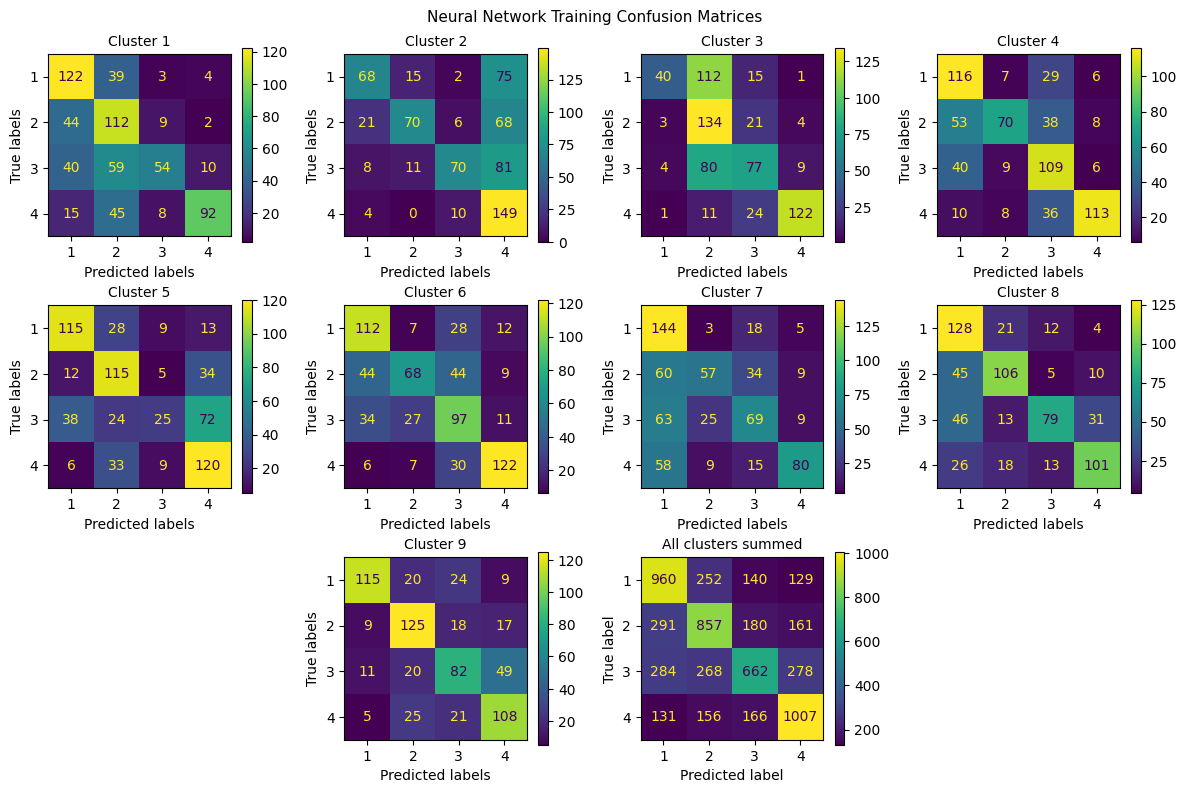

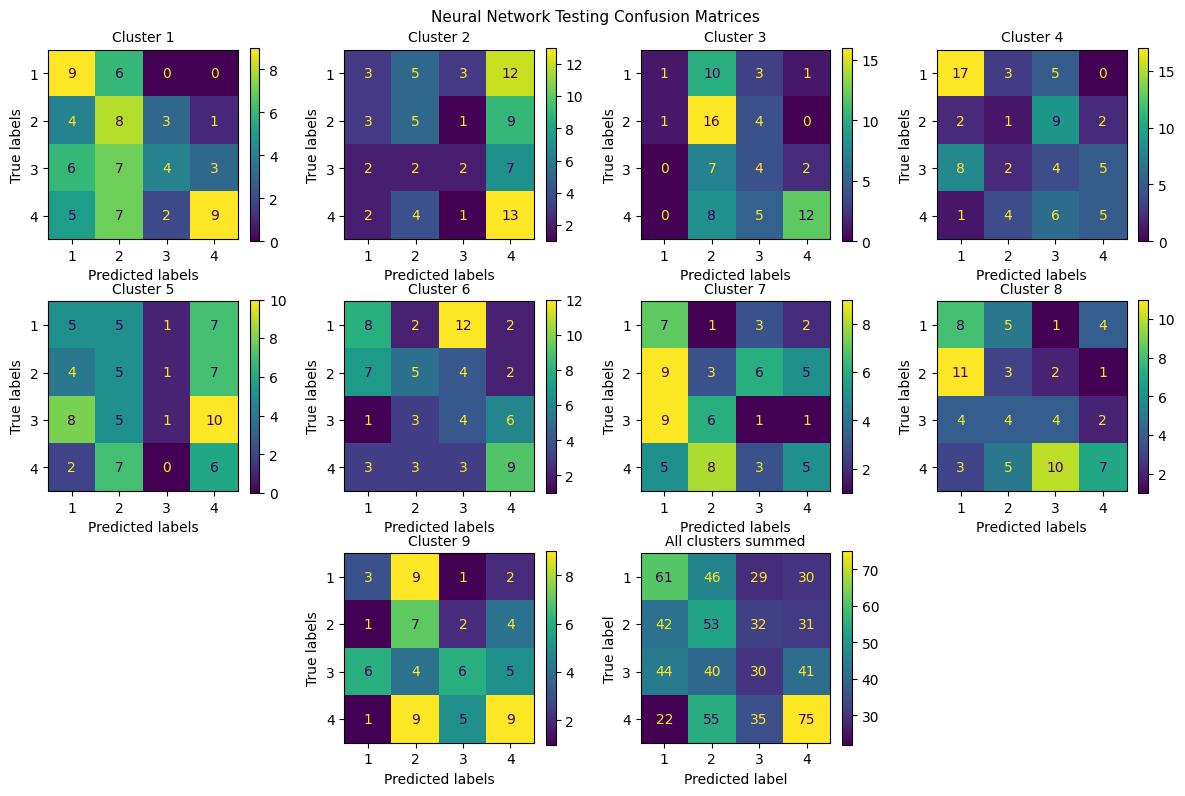

In [38]:
plot_confusion_matrices(nn_train_predictions_all_clusters,nn_train_labels_all_clusters,title="Neural Network Training Confusion Matrices")
plot_confusion_matrices(nn_test_predictions_all_clusters,nn_test_labels_all_clusters, title="Neural Network Testing Confusion Matrices")

### Plot Training and Validation Loss


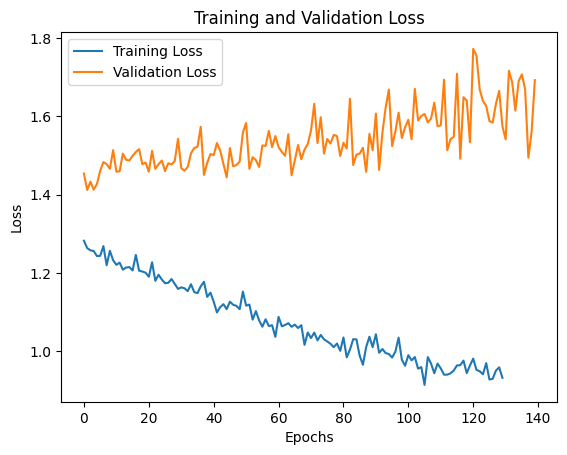

In [39]:
# Plot and label the training and validation loss values
plt.plot(losses[20:], label='Training Loss')
plt.plot(valid_losses[10:], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Implement Logistic Regression


/Users/hayleywalters/Desktop/MLResearch/ML_rain_prediction/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hayleywalters/Desktop/MLResearch/ML_rain_prediction/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

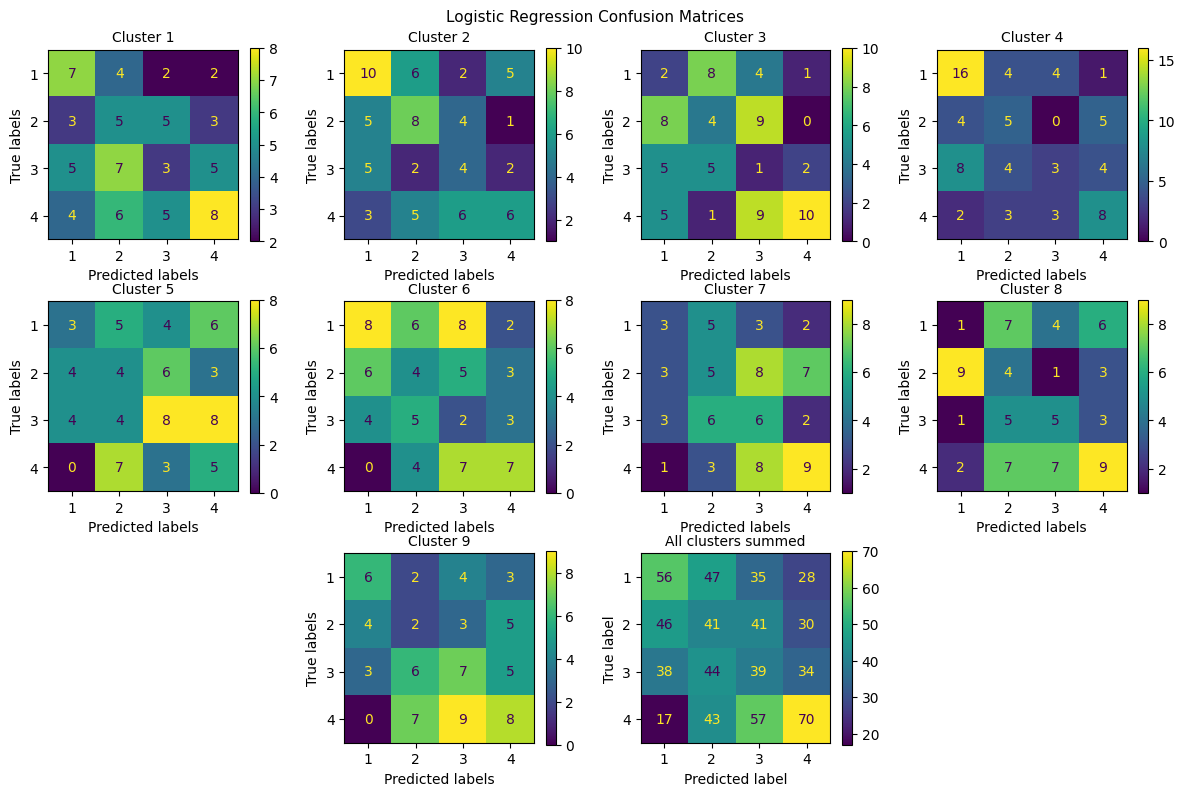

In [40]:
model = LogisticRegression()

test_preds = []
test_labels = []

for i in range(len(clusters)):
# Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    test_preds.append(preds.tolist())
    test_labels.append(y_test.tolist())

plot_confusion_matrices(test_preds, test_labels,title="Logistic Regression Confusion Matrices")